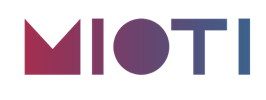
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S6: Reconocimiento facial

## Objetivos

El objetivo de este challenge es evaluar distintos clasificadores sobre un dataset de reconocimiento facial.

## Configuración del entorno

In [40]:
%matplotlib inline

from pylab import *
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

In [74]:
def plot_2d_separator(classifier, X, y, fill=False, ax=None, eps=None):
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    
    if eps is None:
        eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()

    ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels, colors="black")

In [41]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

También vamos a cargar algunas funciones que nos resultarán interesantes.

In [42]:
def print_faces(images, target, top_n):
    '''Dibuja las imágenes de las caras'''
    
    # set up the figure size in inches
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(top_n):
        # plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        
        # label the image with the target value
        #p.text(0, 14, str(target[i]), color="red")
        p.text(1, 60, str(i), color="black", size=15)
        p.text(0, 60, str(i), color="yellow", size=15)

## Dataset

Esta vez utilizaremos un dataset de caras para realizar un algoritmo de reconocimiento facial.

In [43]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

In [44]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [45]:
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

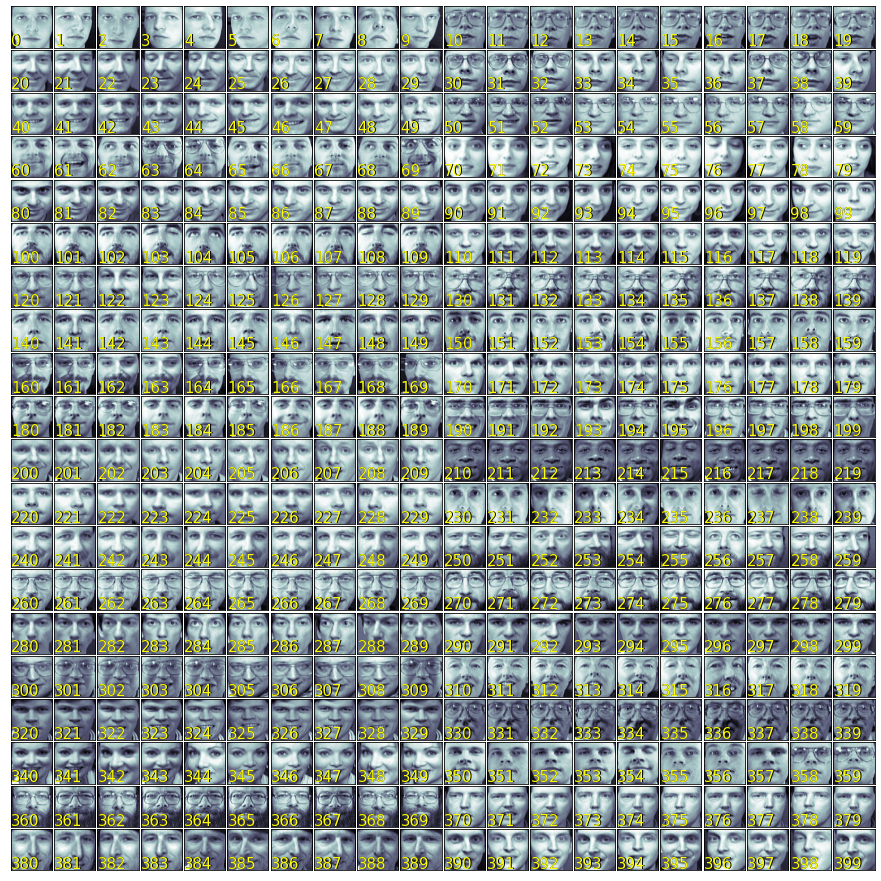

In [46]:
print_faces(faces.images, faces.target, 400)

### Atributos disponibles (X)

Asignamos la variable data a la variable X

In [47]:
dataset_X = faces.data

In [48]:
dataset_X *= 255

In [49]:
dataset_X.shape

(400, 4096)

In [50]:
dataset_X[0]

array([ 79.02893 ,  93.78099 , 106.42561 , ...,  38.987602,  41.095043,
        40.041325], dtype=float32)

In [51]:
import scipy
print(scipy.stats.describe(dataset_X[0]))

DescribeResult(nobs=4096, minmax=(21.074379, 223.38843), mean=162.39595, variance=1451.6178, skewness=-1.9089242219924927, kurtosis=3.2785653690113357)


### Variable objetivo (y)

En este caso, estamos ante un problema de clasificación, la variable a predecir es la persona a la que pertenece cada fotografía de un conjunto de 40 personas.

In [52]:
dataset_y = faces.target

In [53]:
dataset_y.shape

(400,)

In [54]:
print(dataset_y)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

Vamos a simplificar el problema y convertirlo en detectar gente con gafas y gente sin gafas. Como el tamaño del dataset es pequeño (sólo 400 instancias) vamos a reducirlo.

Buscamos a mano la gente con gafas y reclasificamos el vector `y`.

In [55]:
glasses = [(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
           (69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
           (164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
           (194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
           (330, 339), (358, 359), (360, 369)]

In [56]:
transformed_dataset_y = np.zeros(len(dataset_y), dtype=np.int16) 
for g in glasses:
    for i in range(g[0], g[1] + 1):
        transformed_dataset_y[i] = 1
        
print(transformed_dataset_y)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Preprocesado de los datos

Examina los datos de entrenamiento y analiza si es necesario realizar algún preprocesamiento sobre los datos. Si es que sí aplicala.

* Variables que son enumerados
* Valores nulos
* Rango y escalado de los datos

In [29]:
def eval_scaler(scaler, X, y):
    scaler.fit(X)
    scaled_X = scaler.transform(X)
    dibuja_dataset(scaled_X, y)
    return scaled_X

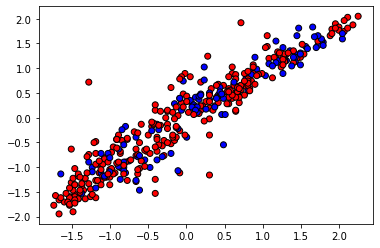

In [34]:
from sklearn.preprocessing import StandardScaler
scaled_X = eval_scaler(StandardScaler(), dataset_X, transformed_dataset_y)

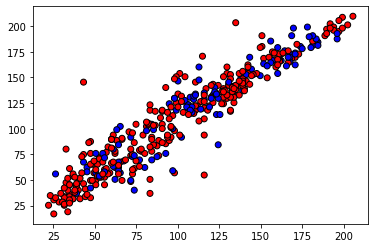

In [69]:
dibuja_dataset(dataset_X, transformed_dataset_y)

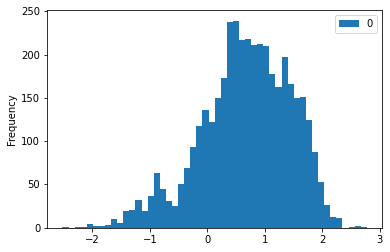

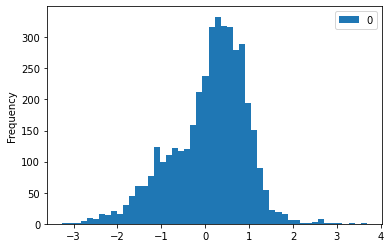

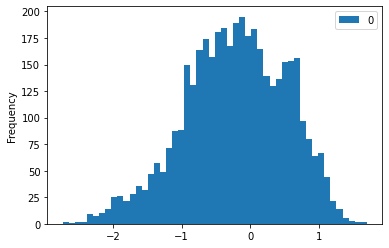

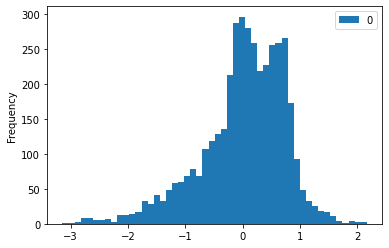

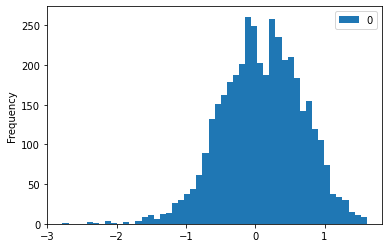

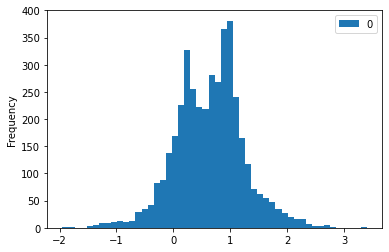

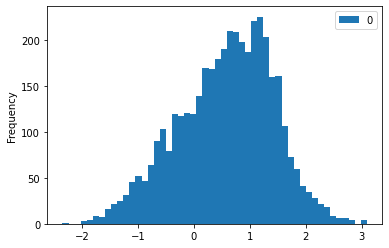

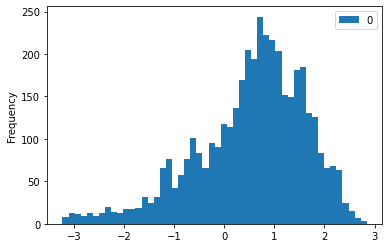

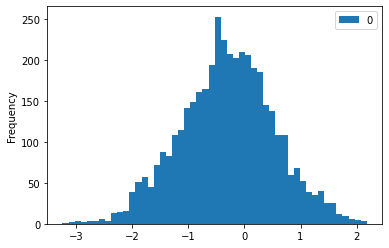

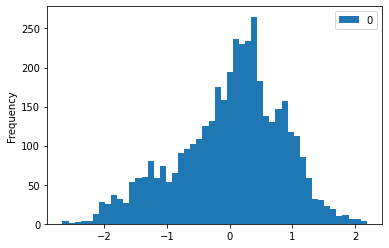

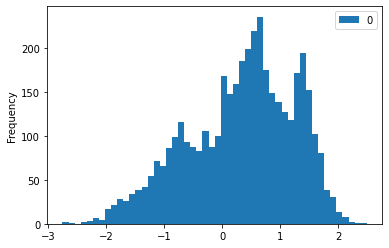

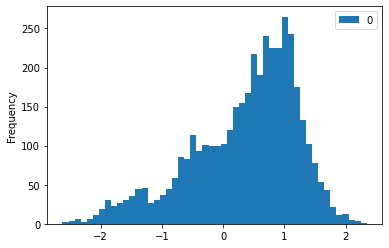

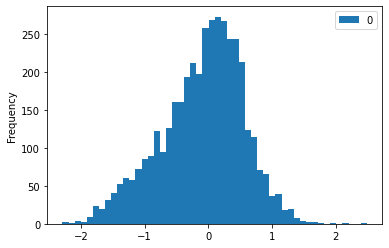

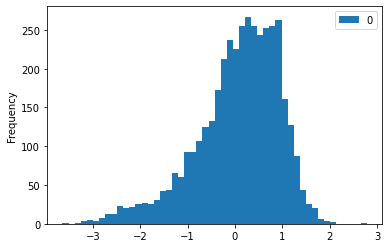

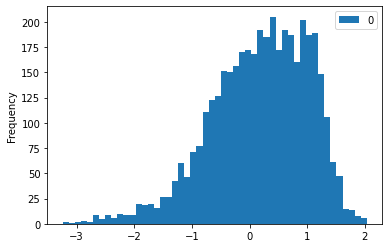

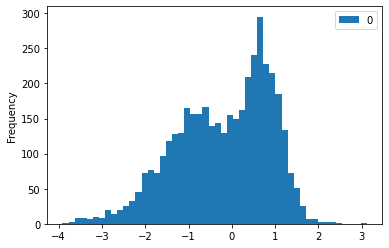

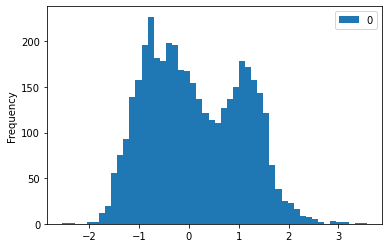

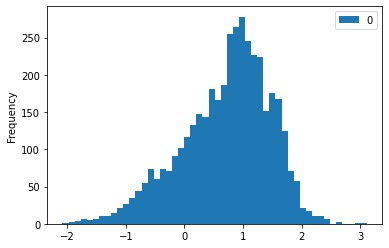

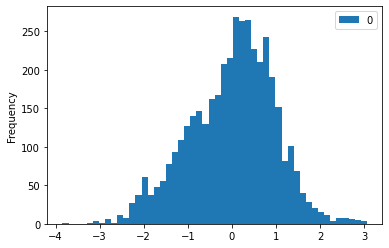

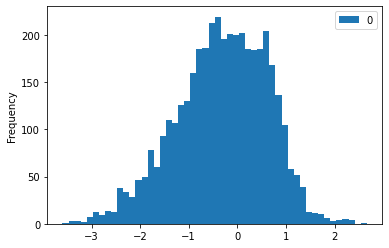

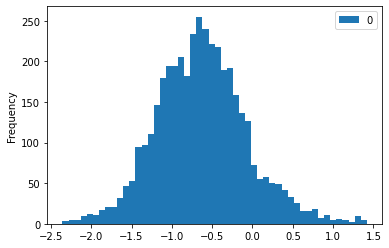

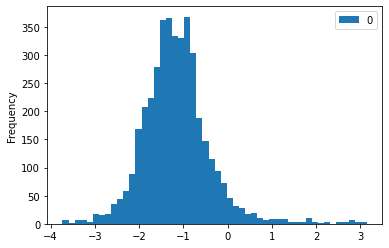

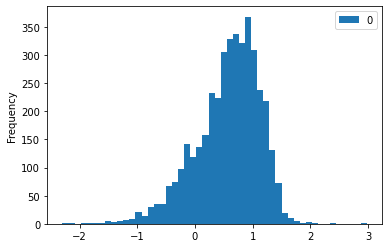

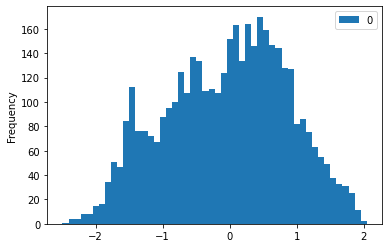

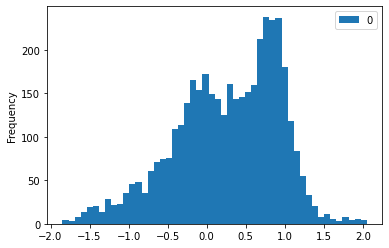

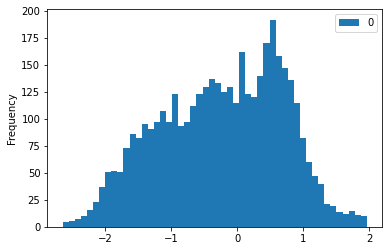

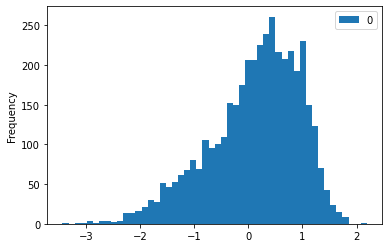

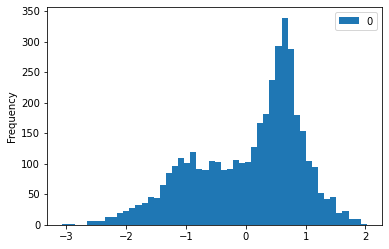

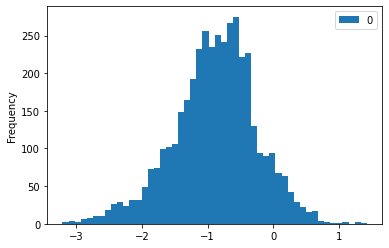

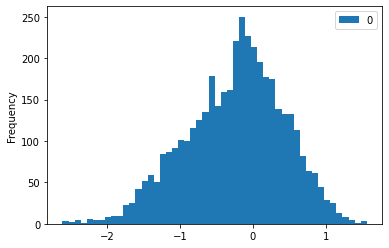

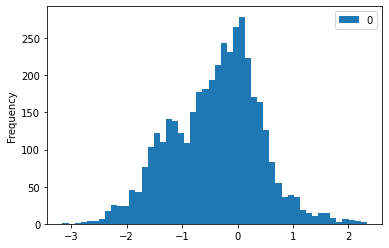

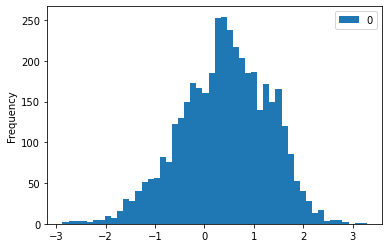

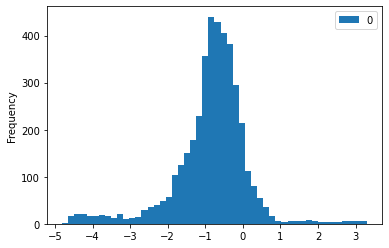

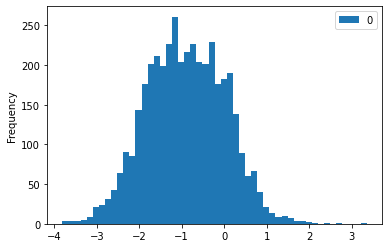

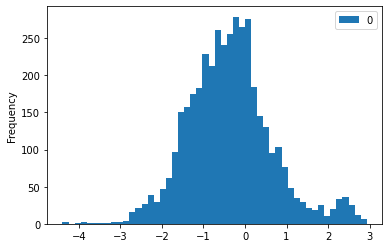

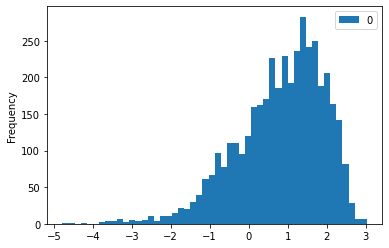

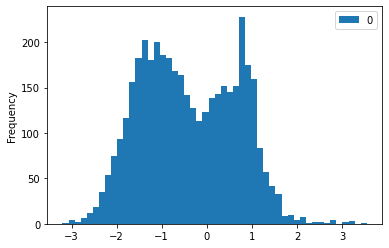

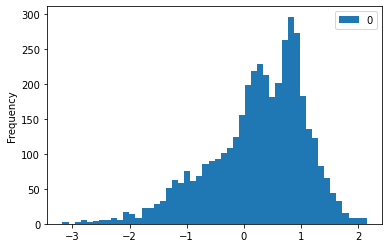

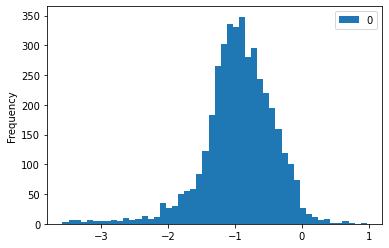

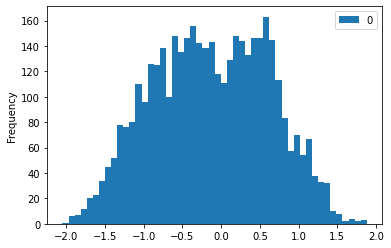

In [39]:
scaled_X
for i in range(0,400,10):
    pd.DataFrame(scaled_X[i]).plot.hist(bins=50)

In [68]:
pd.DataFrame(scaled_X).isnull().values.any()

False

In [67]:
(pd.DataFrame(scaled_X).dtypes != float32).any()

False

## Entrena el modelo y evalúa su rendimiento con distintos datasets

Acuerdate de hacer la división de los datos en conjunto de entrenamiento y test, y utilizar una métrica razonable 🧐 de evaluación.

### Dataset original y variable objetivo: gafas/no gafas

In [60]:
cross_val_score(SVC(),dataset_X,transformed_dataset_y,scoring='roc_auc',cv=5)

array([0.95728452, 0.8578869 , 0.89880952, 0.984375  , 0.97767857])

In [62]:
cross_val_score(SVC(),dataset_X,transformed_dataset_y,scoring='accuracy',cv=5)

array([0.8875, 0.75  , 0.775 , 0.9375, 0.8375])

In [65]:
cross_val_score(SVC(),dataset_X,transformed_dataset_y,scoring='f1',cv=5)

array([0.79069767, 0.41176471, 0.4       , 0.89795918, 0.62857143])

In [86]:
#dataset_X.shape
transformed_dataset_y.shape

(400,)

### Dataset escalado y variable objetivo: gafas/no gafas

In [61]:
#cross_val 5 o 10 Accuracy AUC F1 cross_validation.score // SVM

cross_val_score(SVC(),scaled_X,transformed_dataset_y,scoring='roc_auc',cv=5)

array([0.97177727, 0.92782738, 0.91294643, 0.98735119, 0.98214286])

In [63]:
cross_val_score(SVC(),scaled_X,transformed_dataset_y,scoring='accuracy',cv=5)

array([0.9125, 0.775 , 0.8   , 0.95  , 0.8   ])

In [66]:
cross_val_score(SVC(),scaled_X,transformed_dataset_y,scoring='f1',cv=5)

array([0.8372093 , 0.4375    , 0.5       , 0.91666667, 0.5       ])

#### ¿Se te ocurre alguna manera de mejorar el rendimiento del algoritmo?. 

Puedes probar a evaluar a modificar el parámetro C y ver como se modifican los resultados.

In [87]:
# Escalado -- bucle para cambiar el parametro C y ver metricas

scores = np.array([])
max_c = 15
for i in range(1,max_c):
    salida = cross_val_score(SVC(C=i),scaled_X,transformed_dataset_y,scoring='roc_auc',cv=5)
    print("Cs{:2d} Roc AUC={:3f}".format(i,salida.mean()))
    scores = np.append(scores,salida.mean())
plt.plot(range(1,max_c),scores)


Cs 1 Roc AUC=0.638275
Cs 2 Roc AUC=0.700019
Cs 3 Roc AUC=0.700019
Cs 4 Roc AUC=0.700019
Cs 5 Roc AUC=0.700019
Cs 6 Roc AUC=0.700019
Cs 7 Roc AUC=0.700019
Cs 8 Roc AUC=0.700019
Cs 9 Roc AUC=0.700019
Cs10 Roc AUC=0.700019
Cs11 Roc AUC=0.700019
Cs12 Roc AUC=0.700019
Cs13 Roc AUC=0.700019
Cs14 Roc AUC=0.700019


Cs 1 Roc AUIC=0.935207
Cs 2 Roc AUIC=0.949411
Cs 3 Roc AUIC=0.955070
Cs 4 Roc AUIC=0.956260
Cs 5 Roc AUIC=0.956260
Cs 6 Roc AUIC=0.956260
Cs 7 Roc AUIC=0.956260
Cs 8 Roc AUIC=0.956260
Cs 9 Roc AUIC=0.956260
Cs10 Roc AUIC=0.956260
Cs11 Roc AUIC=0.956260
Cs12 Roc AUIC=0.956260
Cs13 Roc AUIC=0.956260
Cs14 Roc AUIC=0.956260


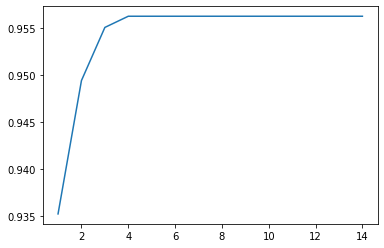

In [73]:
# Sin escalado  -- bucle para cambiar el parametro C y ver metricas

scores = np.array([])
max_c = 15
for i in range(1,max_c):
    salida = cross_val_score(SVC(C=i),dataset_X,transformed_dataset_y,scoring='roc_auc',cv=5)
    print("Cs{:2d} Roc AUC={:3f}".format(i,salida.mean()))
    scores = np.append(scores,salida.mean())
plt.plot(range(1,max_c),scores)

## ¿Qué conclusiones obtienes?